In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from spatialkfold.blocks import spatial_blocks
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneGroupOut, cross_validate, RandomizedSearchCV, GroupKFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os,sys,glob,warnings,joblib

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
plt.style.use("bmh")

# Data Prepration

In [4]:
data = pd.read_csv("../results/CSVs/02_Train_generated_features.csv", parse_dates=["date"])

In [5]:
data.dropna(inplace=True) # Drop NAN generated by Lag features

In [6]:
# Create spatial folds
gdf = gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data.lng, data.lat, crs=4326))

blocks = spatial_blocks(gdf=gdf, width=0.05, height=0.05, 
                                  method='continuous', orientation='tb-lr' ,
                                  nfolds=10, random_state= 175)

stn_block = gpd.overlay (gdf, blocks)

In [7]:
selected_FTs = ['hydrometric_level',
                'pm10',
                'so2',
                'no2',
                'temperature_lag_15',
                'temperature_lag_30',
                'precipitation',
                'humidity',
                'N',
                'E',
                'SW',
                'dtm_milan',
                'aspect', 
                'dusaf15',
                'geologia',
                'hillshade',
                'ndvi_2019',
                'plan_curvature',
                'profile_curvature',
                'water_distance',
                'slope',
                'tri',
                'twi',
                'geo_0',
                'geo_1',
                'geo_2',
                'geo_3',
                'geo_4',
                'geo_5',
                'geo_6',
                'lc_11',
                'lc_12',
                'lc_14',
                'lc_21',
                'lc_22',
                'lc_23',
                'lc_31',
                'lc_32',
                'lc_33',
                'lc_41',
                'precipitation_lag_1',
                'humidity_lag_1',
                'temperature_lag_3',
                'precipitation_lag_3',
                'humidity_lag_3',
                'precipitation_lag_7',
                'precipitation_lag_30',
                'weekend',
                'day_of_year_sin',
                'week_cos',
                'month_sin',
                'month_cos',
                'quarter_cos']

print(f"Number of the selected features:{len(selected_FTs)}")

Number of the selected features:53


In [8]:
random_stations = stn_block["stn_ID"].sample(5, random_state=856)
train = stn_block[~stn_block["stn_ID"].isin(random_stations)]
test = stn_block[stn_block["stn_ID"].isin(random_stations)]

In [9]:
X_train = train[selected_FTs]
y_train = train["pm25"]

X_test = test[selected_FTs]
y_test = test["pm25"]

sp_folds = train.folds.values.ravel()
tmp_folds = train.date.values.ravel()

In [10]:
data.shape, stn_block.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((90051, 79), (90051, 81), (79209, 53), (79209,), (10842, 53), (10842,))

# Baseline Models

## Linear Model

In [11]:
lr_full_data = LinearRegression()
lr_full_data.fit(X_train,y_train)
y_pred = lr_full_data.predict(X_train)

print(f"The Train R² for linear model is: {r2_score(y_train,y_pred):.2f}")
print(f"The Train MAE for linear model is: {mean_absolute_error(y_train,y_pred):.2f}")
print(f"The Train RMSE for linear model is: {root_mean_squared_error(y_train,y_pred):.2f}")

The Train R² for linear model is: 0.93
The Train MAE for linear model is: 2.85
The Train RMSE for linear model is: 4.01


### Test Data

In [12]:
y_pred = lr_full_data.predict(X_test)

print(f"The Test R² for linear model is: {r2_score(y_test,y_pred):.2f}")
print(f"The Test MAE for linear model is: {mean_absolute_error(y_test,y_pred):.2f}")
print(f"The Test RMSE for linear model is: {root_mean_squared_error(y_test,y_pred):.2f}")

The Test R² for linear model is: 0.93
The Test MAE for linear model is: 2.79
The Test RMSE for linear model is: 3.99


### Validation

In [13]:
lr = LinearRegression()
sptial_cvs = LeaveOneGroupOut()
temporal_cvs = GroupKFold(n_splits=10)

### Spatial Cross-validation

In [14]:
lr_cvsp_results = cross_validate(lr, X_train, y_train, cv=sptial_cvs.split(X_train, y_train, sp_folds), 
                                 scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], 
                                 error_score='raise')


lr_spatial_r2 = lr_cvsp_results["test_r2"].mean()
lr_spatial_mae = np.abs(lr_cvsp_results["test_neg_mean_absolute_error"]).mean()
lr_spatial_rmse = np.abs(lr_cvsp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Spatial CV R² for linear model is: {lr_spatial_r2:.2f}")
print(f"The Spatial CV MAE for linear model is: {lr_spatial_mae:.2f}")
print(f"The Spatial CV RMSE for linear model is: {lr_spatial_rmse:.2f}")

The Spatial CV R² for linear model is: 0.93
The Spatial CV MAE for linear model is: 2.91
The Spatial CV RMSE for linear model is: 4.04


### Temporal Cross-validdation

In [15]:
lr_cvtmp_results = cross_validate(lr, X_train, y_train, cv=temporal_cvs.split(X_train, y_train, tmp_folds), 
                                  scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"],
                                  error_score='raise')


lr_temporal_r2 = lr_cvtmp_results["test_r2"].mean()
lr_temporal_mae = np.abs(lr_cvtmp_results["test_neg_mean_absolute_error"]).mean()
lr_temporal_rmse = np.abs(lr_cvtmp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Temporal CV R² for linear model is: {lr_temporal_r2:.2f}")
print(f"The Temporal CV MAE for linear model is: {lr_temporal_mae:.2f}")
print(f"The Temporal CV RMSE for linear model is: {lr_temporal_rmse:.2f}")

The Temporal CV R² for linear model is: 0.93
The Temporal CV MAE for linear model is: 2.89
The Temporal CV RMSE for linear model is: 4.03


## Random forest

In [16]:
rf_full_data = RandomForestRegressor(n_jobs=90,random_state=143)
rf_full_data.fit(X_train,y_train)
y_pred = rf_full_data.predict(X_train)

print(f"The Train R² for RF model is: {r2_score(y_train,y_pred):.2f}")
print(f"The Train MAE for RF model is: {mean_absolute_error(y_train,y_pred):.2f}")
print(f"The Train RMSE for RF model is: {root_mean_squared_error(y_train,y_pred):.2f}")

The Train R² for RF model is: 1.00
The Train MAE for RF model is: 0.18
The Train RMSE for RF model is: 0.38


### Test Data

In [17]:
y_pred = rf_full_data.predict(X_test)

print(f"The Test R² for RF model is: {r2_score(y_test,y_pred):.2f}")
print(f"The Test MAE for RF model is: {mean_absolute_error(y_test,y_pred):.2f}")
print(f"The Test RMSE for RF model is: {root_mean_squared_error(y_test,y_pred):.2f}")

The Test R² for RF model is: 0.99
The Test MAE for RF model is: 0.65
The Test RMSE for RF model is: 1.10


### Validation

In [18]:
rf = RandomForestRegressor(n_jobs=90,random_state=143)

### Spatial Cross-validation

In [19]:
rf_cvsp_results = cross_validate(rf, X_train, y_train, cv=sptial_cvs.split(X_train, y_train, sp_folds),
                                 scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"],
                                 error_score='raise',
                                 n_jobs = 10)

rf_spatial_r2 = rf_cvsp_results["test_r2"].mean()
rf_spatial_mae = np.abs(rf_cvsp_results["test_neg_mean_absolute_error"]).mean()
rf_spatial_rmse = np.abs(rf_cvsp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Spatial CV R² for RF model is: {rf_spatial_r2:.2f}")
print(f"The Spatial CV MAE for RF model is: {rf_spatial_mae:.2f}")
print(f"The Spatial CV RMSE for RF model is: {rf_spatial_rmse:.2f}")

The Spatial CV R² for RF model is: 0.99
The Spatial CV MAE for RF model is: 0.68
The Spatial CV RMSE for RF model is: 1.19


### Temporal Cross-validdation

In [20]:
rf_cvtmp_results = cross_validate(rf,  X_train, y_train, cv=temporal_cvs.split(X_train, y_train, tmp_folds), 
                                  scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], 
                                  error_score='raise',
                                  n_jobs=10)

rf_temporal_r2 = rf_cvtmp_results["test_r2"].mean()
rf_temporal_mae = np.abs(rf_cvtmp_results["test_neg_mean_absolute_error"]).mean()
rf_temporal_rmse = np.abs(rf_cvtmp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Temporal CV R² for RF model is: {rf_temporal_r2:.2f}")
print(f"The Temporal CV MAE for RF model is: {rf_temporal_mae:.2f}")
print(f"The Temporal CV RMSE for RF model is: {rf_temporal_rmse:.2f}")

The Temporal CV R² for RF model is: 0.92
The Temporal CV MAE for RF model is: 2.99
The Temporal CV RMSE for RF model is: 4.35


# Model Optimization

In [21]:
# set up the model
rf = RandomForestRegressor(n_jobs=100,random_state=569)

# determine the hyperparameter space
param_grid = dict(
    n_estimators=stats.randint(10, 120),
    min_samples_split=stats.uniform(0, 1),
    max_depth=stats.randint(1, 5),
    max_features=('sqrt', 'log2', None)
    )


# set up the search
final_model = RandomizedSearchCV(rf,
                            param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=temporal_cvs.split(X_train, y_train, tmp_folds),
                            n_iter = 60,
                            random_state=10,
                            n_jobs=15,
                            refit=True)


# find best hyperparameters
final_model.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f59d16fe970>,
                   estimator=RandomForestRegressor(n_jobs=100,
                                                   random_state=569),
                   n_iter=60, n_jobs=15,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f59d183c460>,
                                        'max_features': ('sqrt', 'log2', None),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f59d17df1c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f59d183ca00>},
                   random_state=10, scoring='neg_root_mean_squared_error')

In [22]:
final_model.best_params_

{'max_depth': 4,
 'max_features': None,
 'min_samples_split': 0.048628006263405577,
 'n_estimators': 62}

In [23]:
# Save the model
joblib.dump(final_model.best_estimator_, f'../results/models/pm25_RF_v1.0.0.pkl')

['../results/models/pm25_RF_v1.0.0.pkl']

## Validation

In [24]:
y_pred = final_model.predict(X_train)

print(f"The Train R² for RF model is: {r2_score(y_train,y_pred):.2f}")
print(f"The Train MAE for RF model is: {mean_absolute_error(y_train,y_pred):.2f}")
print(f"The Train RMSE for RF model is: {root_mean_squared_error(y_train,y_pred):.2f}")

The Train R² for RF model is: 0.92
The Train MAE for RF model is: 2.98
The Train RMSE for RF model is: 4.19


In [25]:
y_pred = final_model.predict(X_test)

print(f"The Test R² for RF model is: {r2_score(y_test,y_pred):.2f}")
print(f"The Test MAE for RF model is: {mean_absolute_error(y_test,y_pred):.2f}")
print(f"The Test RMSE for RF model is: {root_mean_squared_error(y_test,y_pred):.2f}")

The Test R² for RF model is: 0.92
The Test MAE for RF model is: 2.86
The Test RMSE for RF model is: 4.13


In [26]:
rf_cvsp_results = cross_validate(RandomForestRegressor(n_jobs=100,random_state=569,**final_model.best_params_), X_train, y_train, cv=sptial_cvs.split(X_train, y_train, sp_folds),
                                 scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"],
                                 error_score='raise',
                                 n_jobs = 10)

rf_spatial_r2 = rf_cvsp_results["test_r2"].mean()
rf_spatial_mae = np.abs(rf_cvsp_results["test_neg_mean_absolute_error"]).mean()
rf_spatial_rmse = np.abs(rf_cvsp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Spatial CV R² for RF model is: {rf_spatial_r2:.2f}")
print(f"The Spatial CV MAE for RF model is: {rf_spatial_mae:.2f}")
print(f"The Spatial CV RMSE for RF model is: {rf_spatial_rmse:.2f}")

The Spatial CV R² for RF model is: 0.92
The Spatial CV MAE for RF model is: 2.96
The Spatial CV RMSE for RF model is: 4.15


In [27]:
rf_cvtmp_results = cross_validate(RandomForestRegressor(n_jobs=100,**final_model.best_params_),  X_train, y_train, cv=temporal_cvs.split(X_train, y_train, tmp_folds), 
                                  scoring= ["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], 
                                  error_score='raise',
                                  n_jobs=10)

rf_temporal_r2 = rf_cvtmp_results["test_r2"].mean()
rf_temporal_mae = np.abs(rf_cvtmp_results["test_neg_mean_absolute_error"]).mean()
rf_temporal_rmse = np.abs(rf_cvtmp_results["test_neg_root_mean_squared_error"]).mean()

print(f"The Temporal CV R² for RF model is: {rf_temporal_r2:.2f}")
print(f"The Temporal CV MAE for RF model is: {rf_temporal_mae:.2f}")
print(f"The Temporal CV RMSE for RF model is: {rf_temporal_rmse:.2f}")

The Temporal CV R² for RF model is: 0.91
The Temporal CV MAE for RF model is: 3.17
The Temporal CV RMSE for RF model is: 4.43


In [28]:
station = test[(test.stn_ID == test.stn_ID.sample().values[0]) & (test.date >="01.01.2018") & (test.date <="31.12.2018")]

In [30]:
station.loc[:,"pm25_pred"] = final_model.predict(station[selected_FTs])

In [31]:
station.set_index("date",inplace=True)

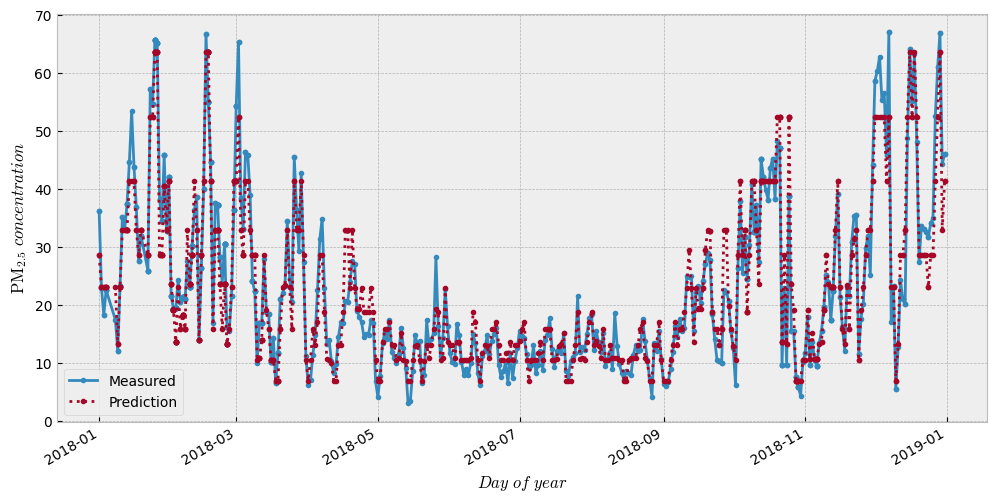

In [32]:
fig, ax = plt.subplots(1,1 , figsize=(12, 6))
station["pm25"].plot(marker=".")
station["pm25_pred"].plot(linestyle=":",marker=".")

plt.ylabel("$\\mathrm{PM}_{2.5}\ concentration$")
ax.set_xlabel("$Day\ of\ year$")

plt.legend(["Measured", "Prediction"])
plt.savefig("../results/figures/temporal_prediction", dpi=300,bbox_inches="tight")
plt.show()